# NNet class in Pytorch

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [2]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

Complete the following definition of class `NNet` by completing its `train` and `use` functions.  These functions must be completed the *PyTorch* way, which is **not** identical to how you completed the network in A2 (though the same principles apply)!

In [32]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh', gpu=False):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []

        self.gpu = False

        if gpu:
            self.gpu = True
            self = self.cuda()
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()

        if self.gpu:
            X = X.cuda()
            T = T.cuda()
            
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        W = torch.zeros((2, 1), requires_grad=True)

        for epoch in range(n_epochs):

            # Do forward pass to calculate output Y.
            #Y = X @ W[1:, :] + W[0:1, :]
            Y = self.forward(X)

            # Calculate mean squared error loss, mse.
            mse = mse_func(T, Y)

            # Calculate gradient of mse with respect to all weights by calling mse.backward().
            mse.backward()

            # Take weight update step, then zero the gradient values.
            optimizer.step()
            optimizer.zero_grad()

            # Convert mse error to rmse error for error tracing.
            rmse = torch.sqrt(mse)

            # Unstandardize the rmse error and save in self.error_trace
            error = (rmse * self.Tstds)[0]
            self.error_trace.append(error)

            # Print epoch+1 and unstandardized error if verbose is True and
            #   (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
            if ((epoch + 1) == n_epochs or (epoch + 1) % (n_epochs // 10) == 0) and verbose:
                print(f'Epoch {epoch+1:d} RMSE={error:.3f}')
            

    def use(self, X):
 
        # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()

        if self.gpu:
            X = X.cuda()

        # Standardize X
        Xstd = (X - self.Xmeans) / self.Xstds 
        
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
        Y = self.forward(Xstd) * self.Tstds + self.Tmeans
        
        # Return output Y after detaching from computation graph and converting to numpy
        if self.gpu:
            return Y.cpu().detach().numpy()
        else:
            return Y.detach().numpy()


## Example

In [4]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y = net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')

Epoch 5 RMSE=11.155
Epoch 10 RMSE=6.062
Epoch 15 RMSE=5.169
Epoch 20 RMSE=2.103
Epoch 25 RMSE=2.317
Epoch 30 RMSE=2.636
Epoch 35 RMSE=1.463
Epoch 40 RMSE=1.137
Epoch 45 RMSE=1.170
Epoch 50 RMSE=0.922
RMSE 0.867


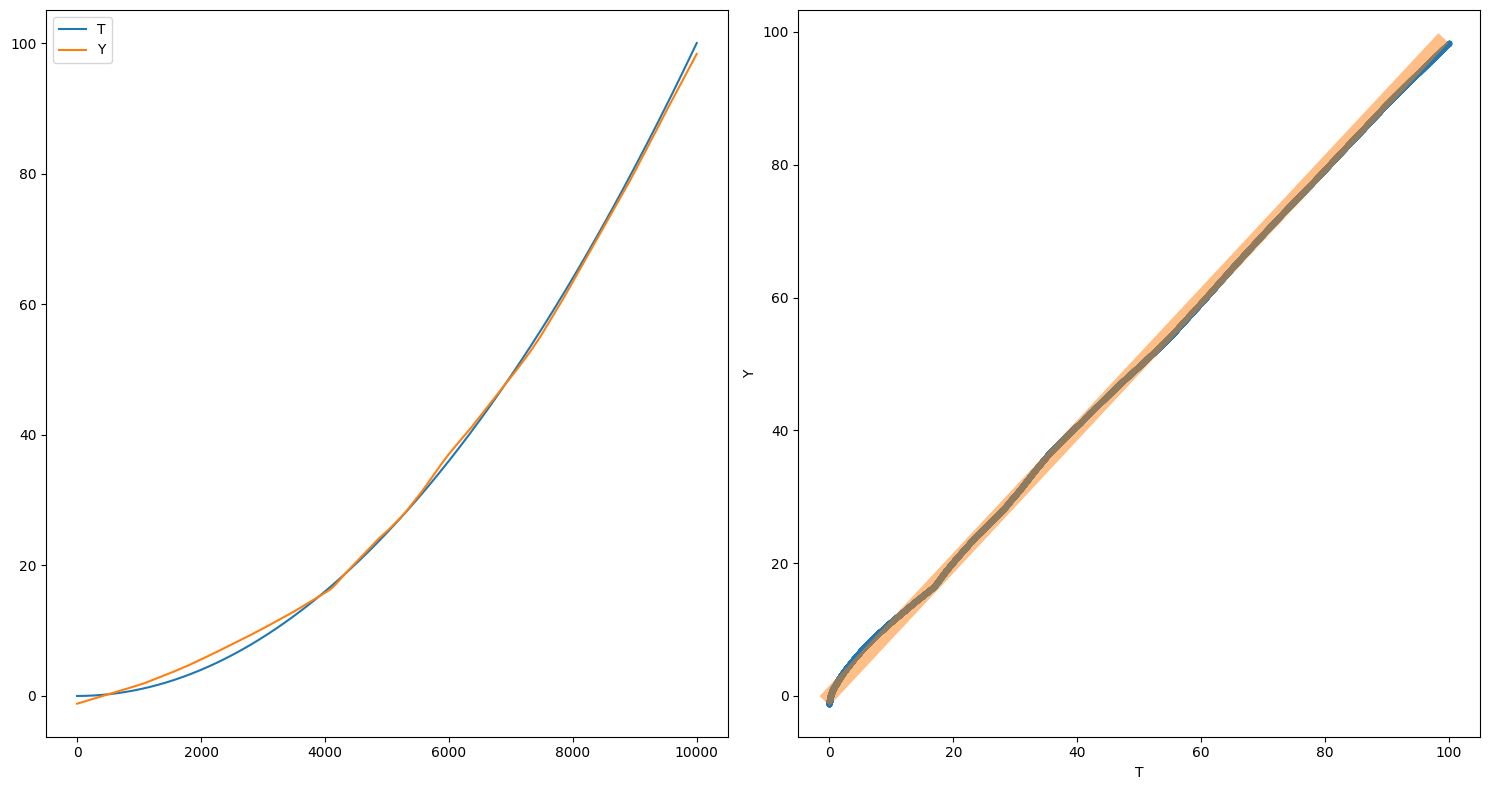

In [5]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

## Implementation

This is complete code for `generate_k_fold_cross_validation_sets`.

In [6]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [7]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]),
 array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [8]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  Append a list of the architecture and these three mean RMSEs to a list of results and return the list as a pandas DataFrame described below when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [27]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func, gpu=False):
    
    result = []

    for n_hiddens in list_of_n_hiddens:
        train_rmse_list = []
        val_rmse_list = []
        test_rmse_list = []
        for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

            n_samples, n_inputs = Xtrain.shape 
            n_outputs = Ttrain.shape[1]

            net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu', gpu=gpu)
            net.train(Xtrain, Ttrain, n_epochs, learning_rate, verbose=False)
            Yvalidate = net.use(Xvalidate)
            Ytest = net.use(Xtest)

            def rmse(Y, T):
                return np.sqrt(np.mean((T - Y)**2))
            
            if gpu:
                train_rmse_list.append(net.error_trace[-1].cpu().detach())
            else:
                train_rmse_list.append(net.error_trace[-1].detach())
            val_rmse_list.append(rmse(Yvalidate, Tvalidate))
            test_rmse_list.append(rmse(Ytest, Ttest))

        train_rmse_avg = np.mean(train_rmse_list)
        #train_rmse_avg = 0
        val_rmse_avg = np.mean(val_rmse_list)
        test_rmse_avg = np.mean(test_rmse_list)
        
        result.append({'Arch': n_hiddens, 'Train RMSE': train_rmse_avg, 'Val RMSE': val_rmse_avg, 'Test RMSE': test_rmse_avg})
    
    return pandas.DataFrame(result, columns=['Arch', 'Train RMSE', 'Val RMSE', 'Test RMSE'])


## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/dataset/291/airfoil+self+noise) and read it as shown below.

In [10]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))

Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described sufficiently.  If you struggle with judging this yourself, you can consider 10 sentences or more of discussion to be sufficient, but 9 perceptive sentences are better than 10 or more sentences of non-analytical fluff.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [41]:
X = airfoil.to_numpy()[:, :5]
T = airfoil.to_numpy()[:, 5:]

print(X.shape) 
print(T.shape)

print(X)
print(T)

(1503, 5)
(1503, 1)
[[8.00000e+02 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [1.00000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 [1.25000e+03 0.00000e+00 3.04800e-01 7.13000e+01 2.66337e-03]
 ...
 [4.00000e+03 1.56000e+01 1.01600e-01 3.96000e+01 5.28487e-02]
 [5.00000e+03 1.56000e+01 1.01600e-01 3.96000e+01 5.28487e-02]
 [6.30000e+03 1.56000e+01 1.01600e-01 3.96000e+01 5.28487e-02]]
[[126.201]
 [125.201]
 [125.951]
 ...
 [106.604]
 [106.224]
 [104.204]]


In [47]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [1, 10], [10], [10, 10], [200], [200, 200]],
                                      200, 0.01, 'tanh')

elapsed = (time.time() - start)
print(f'Took {elapsed:.2f} seconds')
results

Took 18.05 seconds


,Arch,Train RMSE,Val RMSE,Test RMSE
0,[],0.325420,0.465716,0.465925
1,[1],0.494652,0.603249,0.618137
2,"[1, 10]",0.285388,0.316479,0.364330
3,[10],0.122446,0.237876,0.231593
4,"[10, 10]",0.066963,0.182700,0.185296
5,[200],0.013906,0.160442,0.159601
6,"[200, 200]",0.006948,0.135905,0.136866


Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [45]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

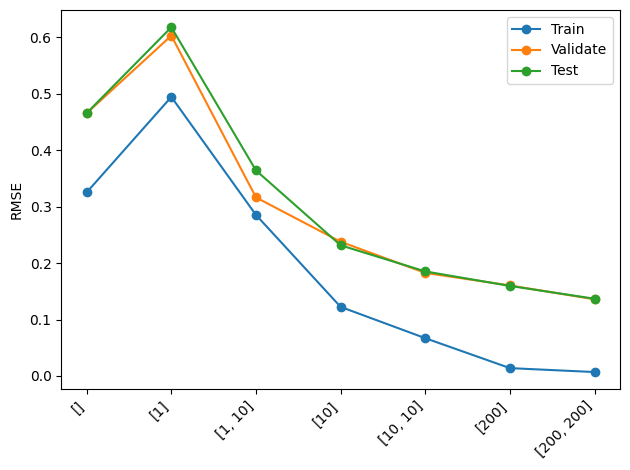

In [48]:
plot_results(results)

There is a increase in the RMSE when comparing the Train results and the Val/Test results, which is to be expected. The model will naturally perform worse on data that it has never seen before. Notably, this difference in RMSE increases as the model's architecture becomes more complex, even as the overall RMSE decreases. This implies that, while increasing the complexity of a model's architecture DOES improve overall performance, it also makes the model more vulnerable to overfitting, a tradeoff that needs to be considered when designing a model.

The only other notable part of these results is the spike in RMSE when moving from a model with no hidden layers (aka a linear model) and a model with a single hidden layer of a single node. This is because, by introducing using such a small architecture, you are introducing nonlinearity to the model but not giving it enough flexibility to accurately approximate the data. This results in an overall worse performance than the linear model. While a simple linear model also won't accurately approximate a dataset with nonlinear features, it will provide a "decent" approximation.

This simple nonlinear model does result in a smaller difference between the Train RMSE and Val/Test RMSE than the linear model, even if the overall RMSE is increased. This is likely because the simple nonlinear model is unable to properly train on the data due to its architecture, resulting in underfitting. This means that this model will perform similarly on the Train and Val/Test sets (similarly worse, that is).

# Grading and Check-In

You will score 90 points if your `train`, `use`, an `run_k_fold_cross_validation` functions are defined correctly. You can test this grading process yourself by downloading [A3grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A3grader.zip) and extracting `A3grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 90/90.  The remaining 10 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [49]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Tone-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='relu')
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='tanh')  # Using tanh
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(400)
    np.random.seed(400)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])
    
    results = run_k_fold

Unlike A2, A3 **should be completed individually**.  Name your notebook as `Lastname-A3.ipynb` with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

# Extra Credit

Earn up to 10 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.  You may need to use one of the campus GPU machines for this.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.  You can earn 5 points for doing (1) and another 5 for doing (2).

In [66]:
internet_usage = pandas.read_csv('internet_usage.csv', delimiter=',',
                          names=('Country Name', 'Country Code', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'),
                          na_values='..')
internet_usage = internet_usage.dropna()

In [70]:
X = internet_usage.to_numpy()[1:, 2:24]
T = internet_usage.to_numpy()[1:, 24:25]
X = X.astype(float)
T = T.astype(float) 

print(X)
print(T)

[[ 0.114097  0.325798  0.390081 ... 68.5504   72.2377   79.3237  ]
 [ 7.03868   9.78081  10.8821   ... 79.947    85.5144   87.1507  ]
 [33.7301   39.1855   36.56     ... 87.7522   87.5294   92.5292  ]
 ...
 [ 0.484347  0.597568  1.08194  ... 70.4      71.1      76.5904  ]
 [ 0.254248  1.26565   1.855    ... 68.6616   70.3      74.21    ]
 [ 1.11131   1.83685   3.10009  ... 70.6226   76.01     81.83    ]]
[[ 82.6137]
 [ 88.3754]
 [ 93.6141]
 [100.    ]
 [ 41.6152]
 [ 94.0078]
 [ 78.8455]
 [ 80.5278]
 [ 79.1269]
 [ 90.6769]
 [ 75.6113]
 [ 82.598 ]
 [ 82.0716]
 [ 89.601 ]
 [ 84.5401]
 [ 97.8601]
 [ 69.7181]
 [ 91.5202]
 [ 92.9888]
 [ 85.3333]
 [ 78.7113]
 [ 91.6298]
 [ 83.1707]
 [ 89.1428]
 [ 66.4846]
 [ 85.0607]
 [ 92.2969]
 [ 97.1686]
 [ 99.8436]
 [ 91.0301]
 [ 87.7242]
 [ 98.242 ]
 [ 27.6609]
 [ 97.3986]
 [ 91.5406]
 [ 78.6322]
 [ 92.5197]
 [ 99.    ]
 [ 97.849 ]
 [ 76.2592]
 [ 86.9411]
 [ 84.4969]
 [ 85.5031]
 [ 90.418 ]
 [100.    ]
 [ 95.9539]
 [ 89.0677]
 [ 88.9125]
 [ 94.4855]
 [ 9

In [71]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results2 = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [1, 10], [10], [10, 10], [200], [200, 200]],
                                      200, 0.01, 'tanh', gpu=True)

elapsed = (time.time() - start)
print(f'Took {elapsed:.2f} seconds')
results2

Took 30.31 seconds


,Arch,Train RMSE,Val RMSE,Test RMSE
0,[],2.214662,2.756747,2.700887
1,[1],5.333659,6.612094,8.104564
2,"[1, 10]",2.908575,5.175603,4.257177
3,[10],0.944528,2.910950,2.775370
4,"[10, 10]",0.786297,2.861449,2.831710
5,[200],0.226143,2.316018,2.277973
6,"[200, 200]",0.113218,3.240321,3.360674


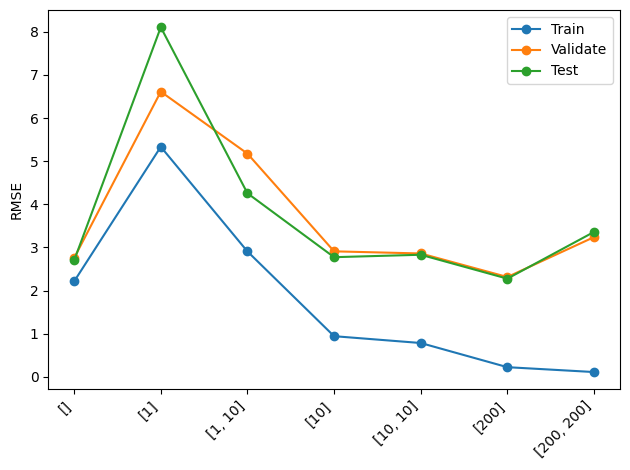

In [72]:
plot_results(results2)

In [73]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results3 = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [1, 10], [10], [10, 10], [200], [200, 200]],
                                      200, 0.01, 'tanh', gpu=False)

elapsed = (time.time() - start)
print(f'Took {elapsed:.2f} seconds')
results3

Took 18.92 seconds


,Arch,Train RMSE,Val RMSE,Test RMSE
0,[],2.214662,2.756746,2.700887
1,[1],5.333658,6.612094,8.104564
2,"[1, 10]",2.908522,5.175547,4.257220
3,[10],0.944515,2.910939,2.775350
4,"[10, 10]",0.786297,2.861449,2.831710
5,[200],0.225838,2.313946,2.280027
6,"[200, 200]",0.166545,3.337602,3.353396


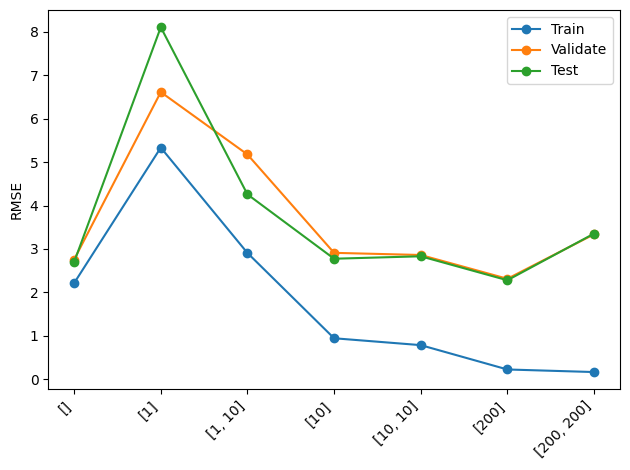

In [74]:
plot_results(results3)

These results follow a similar trend to the results from the Airfoil dataset, but with more varaibility. There is still a spike when going from a linear to nonlinear model, likely for the same reasons as above. There is also a more notable increase in the gap between Train and Val/Test RMSE when using the 200, 200 architecture. This implies that this data is more vulnerable to overfitting than the Airfoil data. The RMSE is also higher in general with this dataset, implying that the relationships in this data are much more complicated and harder to predict, no matter the model architecture.

On my PC, running PyTorch with CUDA actually resulted in a longer runtime than running it without CUDA. This could be a result of a mismatch between my GPU CUDA version and PyTorch CUDA version. It could also mean my dataset is too small, and more time is being spent moving data to/from the GPU than is saved by running the calculations on the GPU.